In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('kaggle-kakr-housing-data\\data', 'train.csv')
test_data_path = join('kaggle-kakr-housing-data\\data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']

del data['price']

In [5]:
train_len = len(data)
data = pd.concat((data, test), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

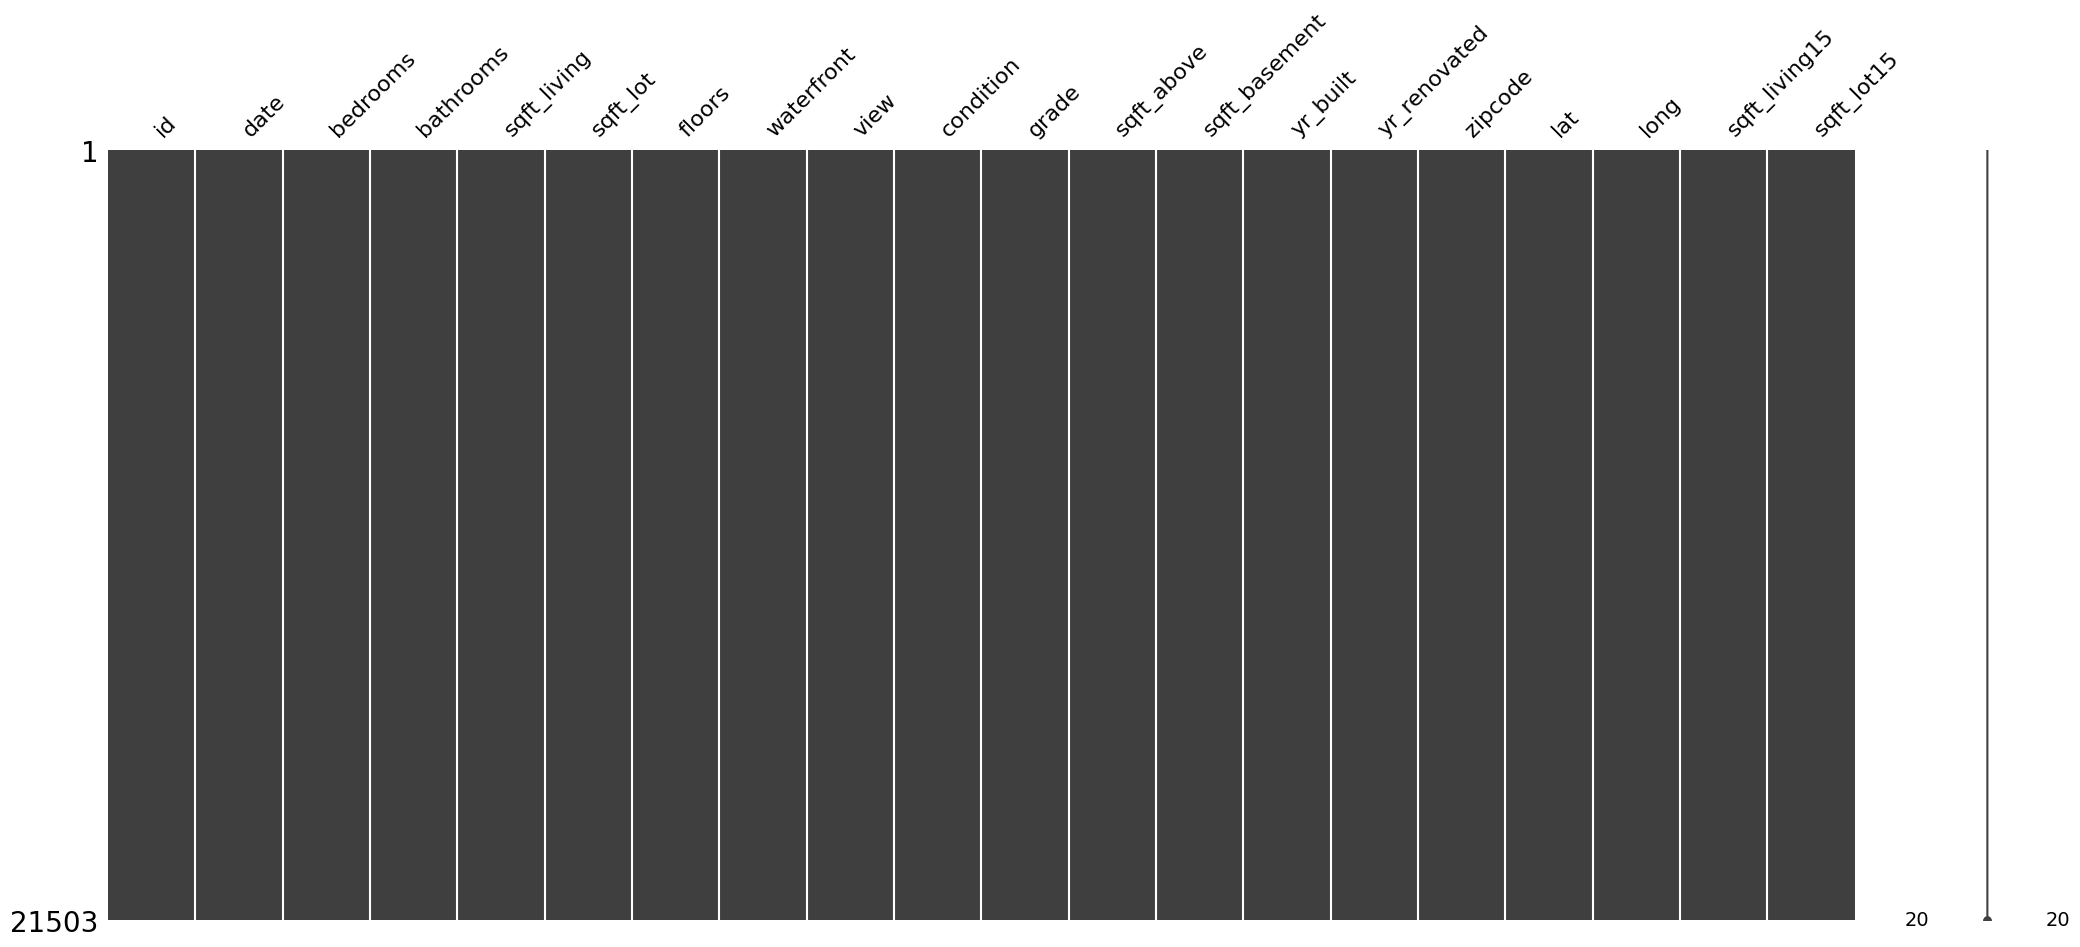

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [9]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

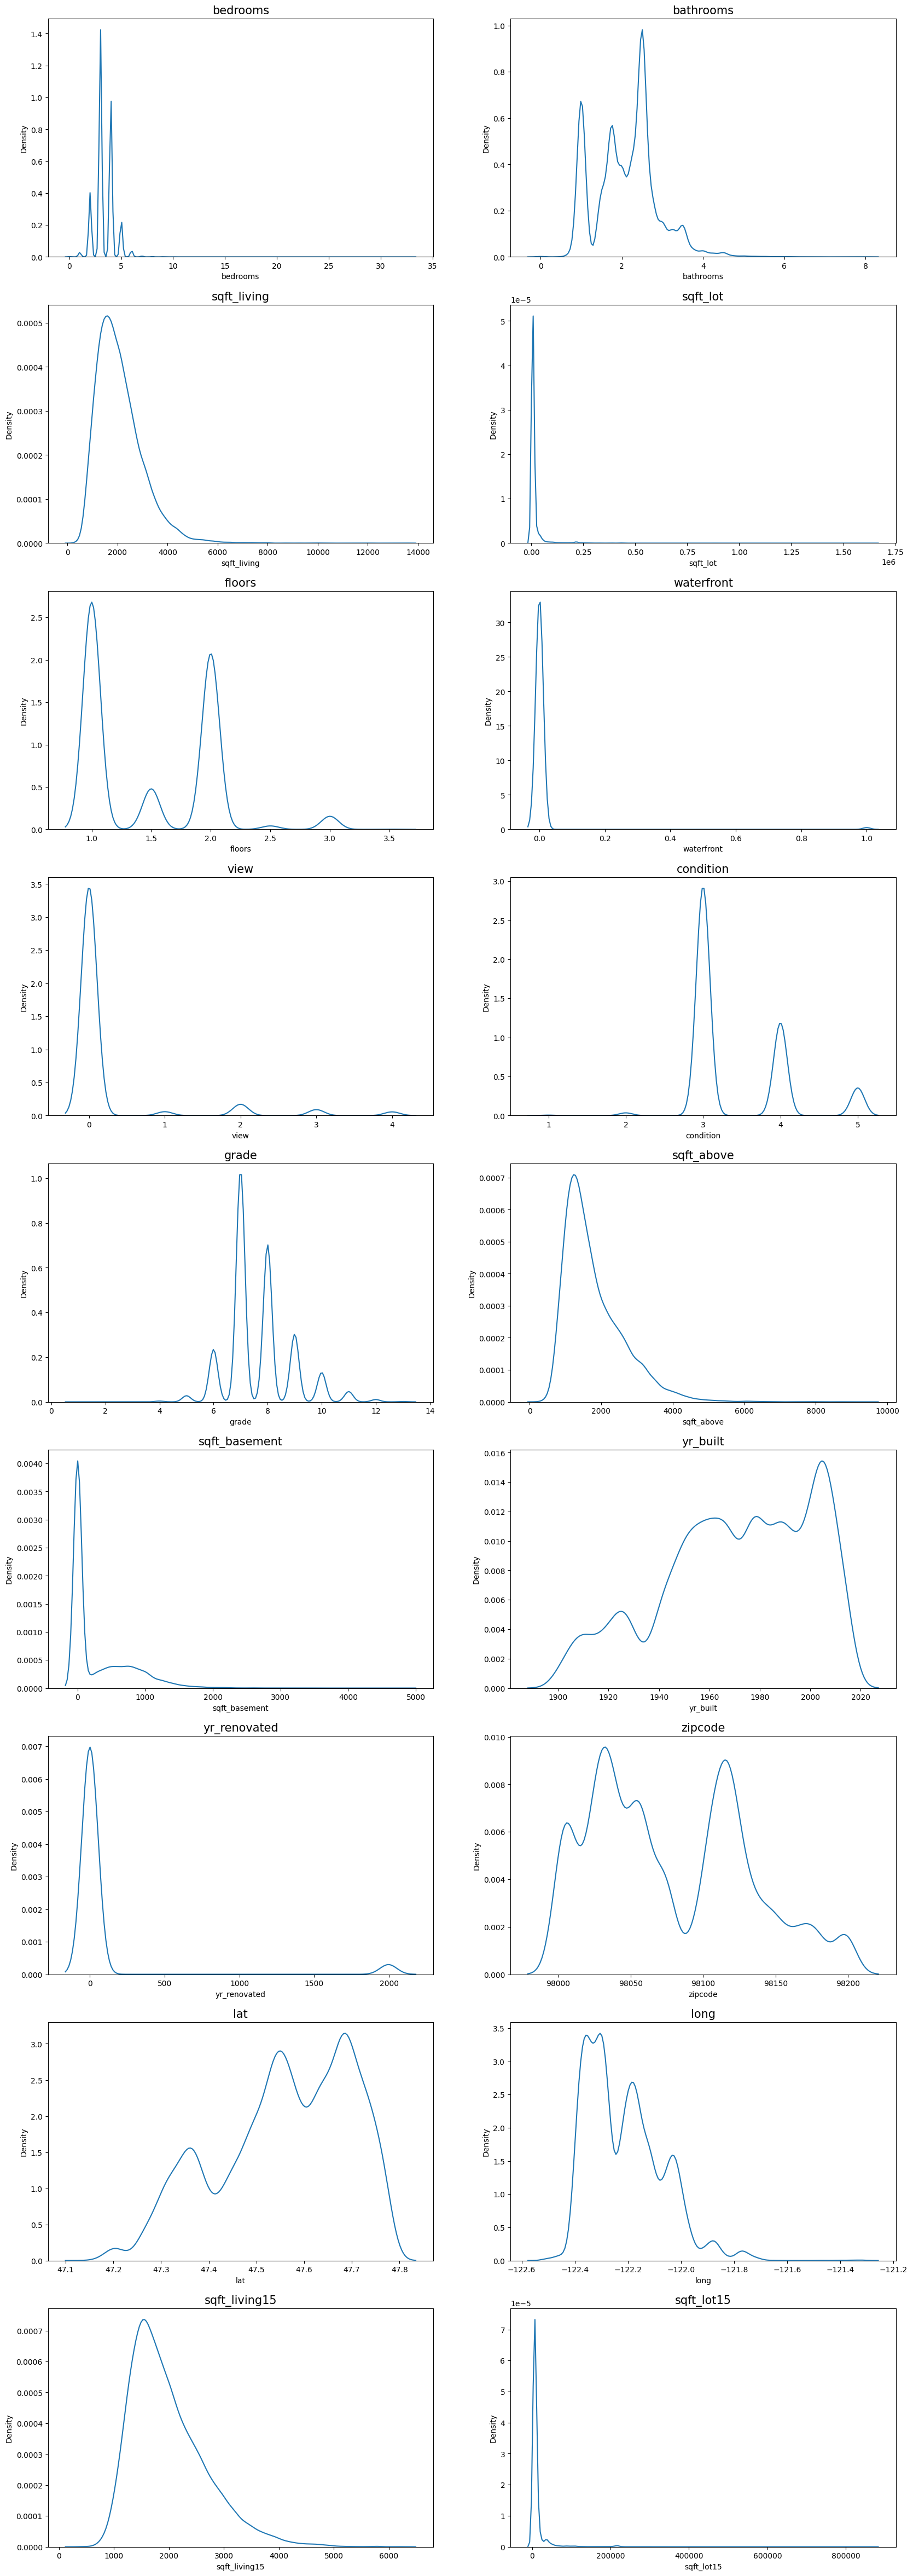

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# date 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_lot15', 'sqft_living15' 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [11]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

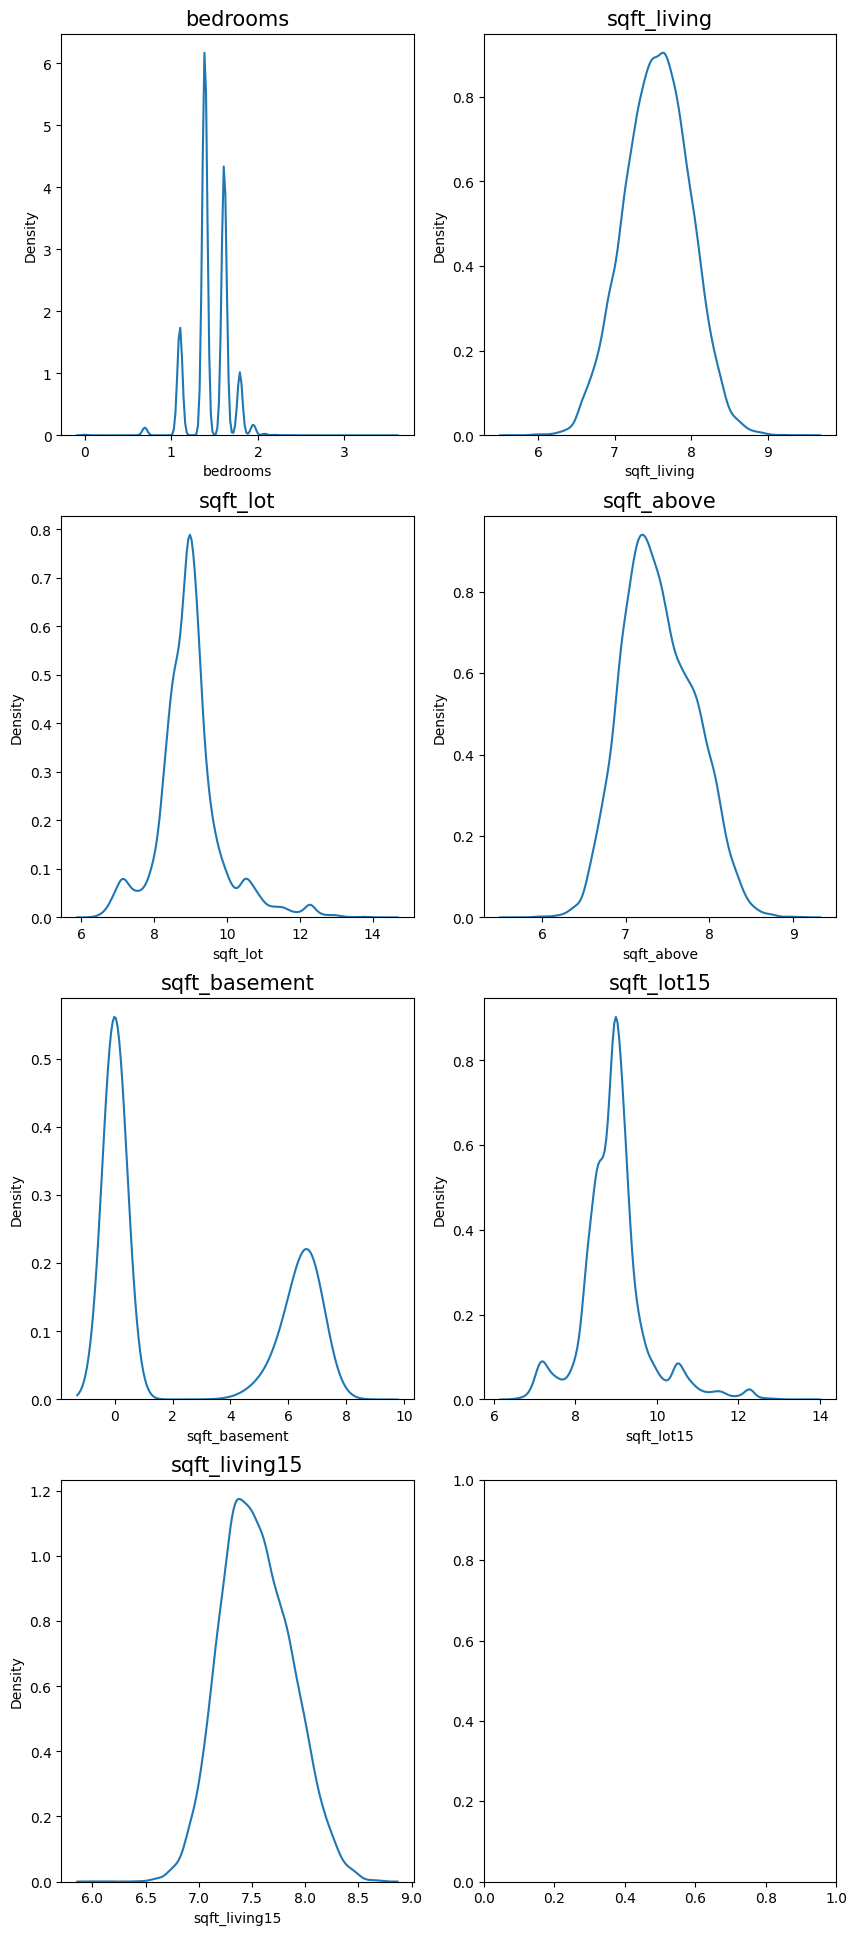

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(10, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

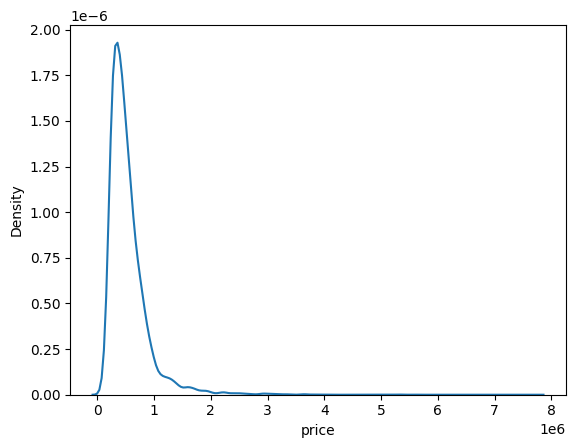

In [13]:
# 한쪽으로 치우친 price의 분포
sns.kdeplot(data=y)
plt.show()

In [14]:
y = np.log1p(y)

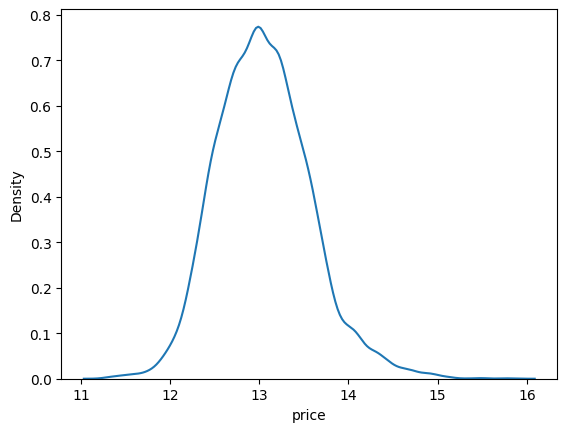

In [15]:
# 치우침이 줄어든 price의 분포
sns.kdeplot(data=y)
plt.show()

In [16]:
train = data.iloc[:train_len, :]  # 학습 데이터
X_test = data.iloc[train_len:, :] # 테스트 데이터

In [17]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

**3.1 하이퍼 파라미터 값 튜닝**

In [18]:
# 랜덤 값을 고정하기 위해 2022 숫자를 모든 모델에 적용
random_state=2022

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(tree_method='gpu_hist', random_state=random_state)
lightgbm = LGBMRegressor(device='gpu',random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

- GridSearch()함수를 이용하여 최적의 파라미터를 찾는 함수 만들기

In [19]:
from sklearn.model_selection import GridSearchCV
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-5):
    '''
    GridSearchCV를 이용하여 제시된 hyper parameter 중 최적의 값을 찾는 함수
    [input params]
        model      : Regressor 모델 1개
        train      : X_train 데이터
        y          : y_train 데이터(정답레이블)
        param_grid : model 에 대한 hyper parameter
        
    [return value]
        pandas.Series
    '''
    # RandomForestRegressor 만 learning_rate 파라미터가 없으므로
    # param_grid 딕셔너리에서 'learning_rate' 만 삭제 처리하는 조건문
    if model.__class__.__name__ == 'RandomForestRegressor':
        param_grid_tmp = param_grid.copy()
        del param_grid_tmp['learning_rate']
        param_grid = param_grid_tmp
    
    print(model.__class__.__name__,param_grid)
    # n_jobs 는 -1 자동으로 cpu코어에 맞추어서 세팅됨
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    # sort_values를 통해 RMSLE 값중에 제일 작은 값이 첫번째 행에 위치 하도록 함
    results.sort_values(by=['RMSLE'],inplace=True)
    # results.iloc[0] 의 이미는 RMSLE값이 최소가 되는 행을 리턴 함
    print(results)
    print('------------')
    return results.iloc[0]

- **param_grid** dictionary 자료형으로 탐색 하고자 하는 하이퍼 파라미터 값의 범위을 정해줍니다

In [20]:
param_grid = {
    'learning_rate':[0.1,0.05,0.01],
    'n_estimators': [1000,1500,2000],
    'max_depth': [1,5,10],
}

In [21]:
def get_best_hyper_params(models, train, y, param_grid, random_state=2022):
    '''
    models 리스트를 순회하면서 모델별로 my_GridSearch()에서 찾은 가장 최적의 파라미터를 데이타프레임 으로 정리
    [input params]
        models    : Regressor모델 묶음
        train     : X_train 데이터
        y         : y_train 데이터(정답레이블)
        param_grid: models 들을 위한 hyper parameter
    [return values]
        pandas.DataFrame
    '''
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        df[model_name]=my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
    
    model_df = pd.DataFrame(df)   
    return model_df

In [22]:
%%time
hyper_param = get_best_hyper_params(models, train, y, param_grid, random_state=2022)

GradientBoostingRegressor {'learning_rate': [0.1, 0.05, 0.01], 'n_estimators': [1000, 1500, 2000], 'max_depth': [1, 5, 10]}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
    learning_rate  max_depth  n_estimators     score     RMSLE
12           0.05          5          1000 -0.026434  0.162587
13           0.05          5          1500 -0.026535  0.162897
14           0.05          5          2000 -0.026676  0.163328
23           0.01          5          2000 -0.026927  0.164094
3            0.10          5          1000 -0.026986  0.164273
4            0.10          5          1500 -0.027347  0.165369
22           0.01          5          1500 -0.027428  0.165614
5            0.10          5          2000 -0.027520  0.165892
21           0.01          5          1000 -0.028491  0.168794
25           0.01         10          1500 -0.029111  0.170621
26           0.01         10          2000 -0.029121  0.170648
24           0.01         10          1000 -0.029153  0.17

In [23]:
hyper_param

,GradientBoostingRegressor,XGBRegressor,LGBMRegressor,RandomForestRegressor
RMSLE,0.162587,0.160622,0.160829,0.186638
learning_rate,0.050000,0.050000,0.010000,NaN
max_depth,5.000000,5.000000,10.000000,10.000000
n_estimators,1000.000000,1000.000000,2000.000000,1000.000000
score,-0.026434,-0.025800,-0.025866,-0.034834


위의 DataFrame과 같이 모델별 최적의 하이퍼 파라미터를 도출해 냈습니다.(learning_rate,max_depth,n_estimators)  
RandomForestRegressor는 learning_rate 파라미터가 없어서 NaN으로 표시됨    
RMSLE 와 score 값은 참고사항으로 넣었습니다  

### 모델 별 성능평가    
이전에 도출해낸 최적의 하이퍼 파라미터를 적용하여 모델별 성능을 평가해 보겠습니다

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [25]:
def get_scores(models, train, y, random_state=2022):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [26]:
def get_cross_value_score(models,train,y):
    df = {}
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        cv_score = np.mean(cross_val_score(estimator=m, X=train.values, y=y,cv=kfold))
        df[m.__class__.__name__]=cv_score
        print("Model {} CV score : {:.4f}".format(m.__class__.__name__,cv_score))
    return pd.DataFrame(df,index=['CrossValScore']).T.sort_values('CrossValScore',ascending=False)

- 이전에 도출한 하이퍼 파라미터를 모델에 적용해 보겠습니다  

In [27]:
random_state=2022

del models
del gboost
del xgboost
del lightgbm
del rdforest

gboost = GradientBoostingRegressor(learning_rate=hyper_param['GradientBoostingRegressor'].learning_rate, \
                                   n_estimators=hyper_param['GradientBoostingRegressor'].n_estimators.astype(int), \
                                   max_depth=hyper_param['GradientBoostingRegressor'].max_depth.astype(int), \
                                   random_state=random_state)

xgboost = XGBRegressor(tree_method='gpu_hist', \
                       learning_rate=hyper_param['XGBRegressor'].learning_rate, \
                       n_estimators=hyper_param['XGBRegressor'].n_estimators.astype(int), \
                       max_depth=hyper_param['XGBRegressor'].max_depth.astype(int), \
                       random_state=random_state)

lightgbm = LGBMRegressor(device='gpu', \
                         learning_rate=hyper_param['LGBMRegressor'].learning_rate, \
                         n_estimators=hyper_param['LGBMRegressor'].n_estimators.astype(int), \
                         max_depth=hyper_param['LGBMRegressor'].max_depth.astype(int), \
                         random_state=random_state)

rdforest = RandomForestRegressor(n_estimators=hyper_param['LGBMRegressor'].n_estimators.astype(int), \
                                 max_depth=hyper_param['LGBMRegressor'].max_depth.astype(int), \
                                 random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

- RMSE값으로 모델을 평가 했습니다.

In [28]:
get_scores(models, train, y, random_state=2022)

,RMSE
RandomForestRegressor,143221.534295
XGBRegressor,125769.679646
LGBMRegressor,120521.383686
GradientBoostingRegressor,117383.782445


- 회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다.

In [29]:
get_cross_value_score(models,train, y)

Model GradientBoostingRegressor CV score : 0.9047
Model XGBRegressor CV score : 0.9071
Model LGBMRegressor CV score : 0.9068
Model RandomForestRegressor CV score : 0.8744


,CrossValScore
XGBRegressor,0.907087
LGBMRegressor,0.906790
GradientBoostingRegressor,0.904748
RandomForestRegressor,0.874421


- 4개 트리 모델 중 LGBMRegressor가 전체적으로 괜찮은 성능을 보여주고 있습니다.<br>

### Make Submission

- 훈련 데이터셋으로 4개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [30]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [31]:
y_pred = AveragingBlending(models, train, y, X_test)

In [32]:
y_pred = np.expm1(y_pred)

In [33]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [34]:
sub.to_csv('submission.csv', index=False)

In [37]:
sub

,id,price
0,15035,5.159686e+05
1,15036,4.870428e+05
2,15037,1.300314e+06
3,15038,2.938063e+05
4,15039,3.326324e+05
...,...,...
6463,21498,2.297917e+05
6464,21499,4.157277e+05
6465,21500,4.794113e+05
6466,21501,3.361944e+05


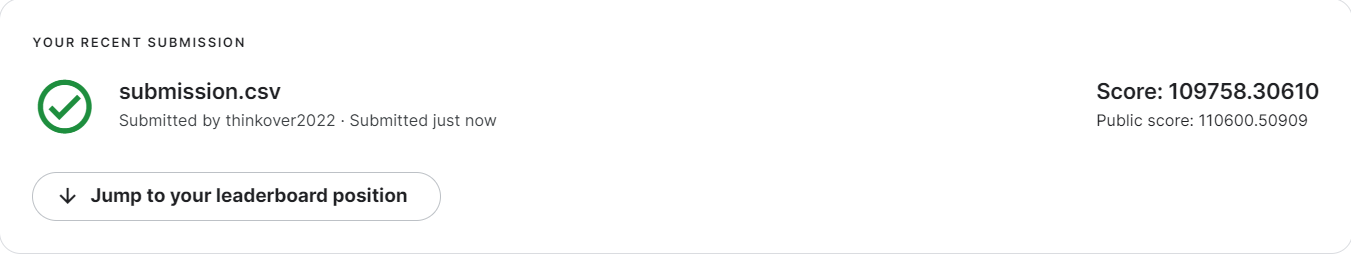